In [3]:
import torch
import torchaudio
import torch.nn.functional as F
import torch.nn as nn
import math
import numpy as np

import torchaudio.compliance.kaldi as kaldi
from matplotlib import pyplot as plt

aishll-1测试集BAC009S0764W0121.wav作为音频，采样率16000
使用kaldi.fbank计算fbank特征，帧长25ms，帧移10ms，

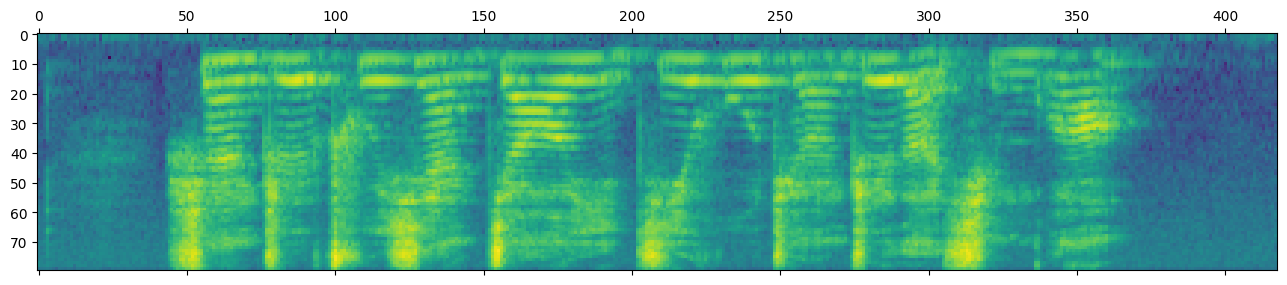

In [19]:
audio = 'BAC009S0764W0121.wav'
waveform, sr = torchaudio.load(audio, num_frames=-1, normalize=True, channels_first=True)
waveform = waveform * (1 << 15)

kaldi_fbank = kaldi.fbank(
        waveform,
        num_mel_bins=80,
        frame_length=25,
        frame_shift=10,
        dither=0.0,
        sample_frequency=16000,
        preemphasis_coefficient=0.97,
        low_freq=0.0
    )
plt.matshow(kaldi_fbank.transpose(0,1).numpy())
plt.show()

In [ ]:
# https://github.com/mravanelli/SincNet
class SincConv_fast(nn.Module):
    """Sinc-based convolution
    Parameters
    ----------
    in_channels : `int`
        Number of input channels. Must be 1.
    out_channels : `int`
        Number of filters.
    kernel_size : `int`
        Filter length.
    sample_rate : `int`, optional
        Sample rate. Defaults to 16000.
    Usage
    -----
    See `torch.nn.Conv1d`
    Reference
    ---------
    Mirco Ravanelli, Yoshua Bengio,
    "Speaker Recognition from raw waveform with SincNet".
    https://arxiv.org/abs/1808.00158
    """

    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)

    def __init__(self, out_channels, kernel_size, sample_rate=16000, in_channels=1,
                 stride=1, padding=0, dilation=1, bias=False, groups=1):

        super(SincConv_fast, self).__init__()

        if in_channels != 1:
            msg = "SincConv only support one input channel (here, in_channels = {%i})" % (in_channels)
            raise ValueError(msg)

        self.out_channels = out_channels
        self.kernel_size = kernel_size

        # Forcing the filters to be odd (i.e, perfectly symmetrics)
        if kernel_size % 2 == 0:
            self.kernel_size = self.kernel_size + 1

        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        if bias:
            raise ValueError('SincConv does not support bias.')
        if groups > 1:
            raise ValueError('SincConv does not support groups.')

        self.sample_rate = sample_rate

        mel = np.linspace(self.to_mel(0),
                          self.to_mel(self.sample_rate / 2),
                          self.out_channels + 1)
        hz = self.to_hz(mel)

        # filter lower frequency (out_channels, 1)
        self.low_hz_ = torch.Tensor(hz[:-1]).view(-1, 1)

        # filter frequency band (out_channels, 1)
        self.band_hz_ = torch.Tensor(np.diff(hz)).view(-1, 1)

        # Hamming window
        # computing only half of the window
        n_lin = torch.linspace(0, (self.kernel_size / 2) - 1, steps=int((self.kernel_size / 2)))
        self.window_ = 0.54 - 0.46 * torch.cos(2 * math.pi * n_lin / self.kernel_size)

        # (1, kernel_size/2)
        n = (self.kernel_size - 1) / 2.0
        self.n_ = 2 * math.pi * torch.arange(-n, 0).view(1, -1) / self.sample_rate  # Due to symmetry, I only need half of the time axes

        f_times_t_low = torch.matmul(self.low_hz_, self.n_)
        f_times_t_high = torch.matmul(self.low_hz_ + self.band_hz_, self.n_)

        band_pass_left = ((torch.sin(f_times_t_high) - torch.sin(f_times_t_low)) / (self.n_ / 2)) * self.window_
        # Equivalent of Eq.4 of the reference paper (SPEAKER RECOGNITION FROM RAW WAVEFORM WITH SINCNET).
        # I just have expanded the sinc and simplified the terms. This way I avoid several useless computations.
        band_pass_center = 2 * self.band_hz_
        band_pass_right = torch.flip(band_pass_left, dims=[1])

        band_pass = torch.cat([band_pass_left, band_pass_center, band_pass_right], dim=1)
        band_pass = band_pass / (2 * self.band_hz_)

        self.filters = band_pass.view(self.out_channels, 1, self.kernel_size)

    def forward(self, waveforms):
        """
        Parameters
        ----------
        waveforms : `torch.Tensor` (batch_size, 1, n_samples)
            Batch of waveforms.
        Returns
        -------
        features : `torch.Tensor` (batch_size, out_channels, n_samples_out)
            Batch of sinc filters activations.
        """

        return F.conv1d(waveforms, self.filters, stride=self.stride,
                        padding=self.padding, dilation=self.dilation,
                        bias=None, groups=1)

https://github.com/mravanelli/SincNet 中的sincnet作为滤波器，帧移stride=1
这里稍微有些改动，将low_hz和band_hz原本可训练参数改成了不可训练值（梅尔滤波器默认值），min_low_hz=50改为了0。因为实验发现，原始的sincnet训练过程中主要是在大幅度的调小第一个滤波器的low_hz，50设置不合理所致，将其置为零，low_hz和band_hz使用梅尔滤波器默认值，sincnet不用训练效果就很好；

sincnet 滤波器之后根据Parseval's theorem（信号的能量在时域和频域相等），根据帧移10ms 做能量相加（用pool代替），即：
** sincnet滤波-> 幅度平方 -> pool平滑 -> 取对数 ** ，就可以获得基于sincnet的fbank特征

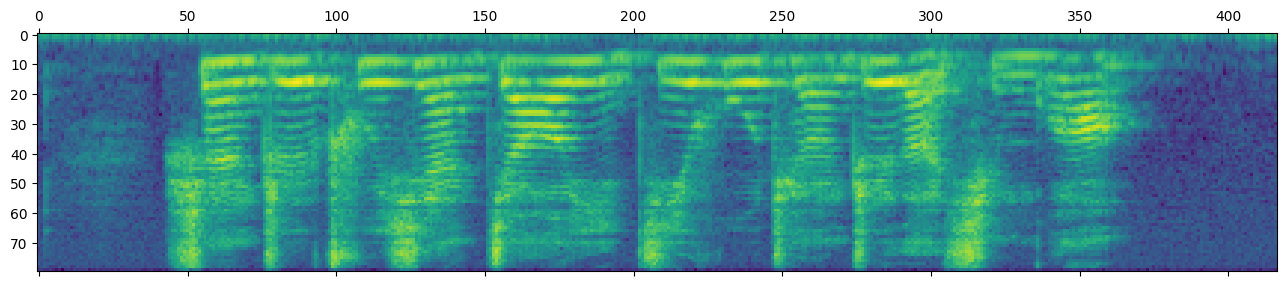

In [20]:
class SincnetFbank(nn.Module):
    def __init__(self, 
                 num_mel_bins=80,
                 frame_length=25,
                 frame_shift=10,
                 sample_frequency=16000,
                 dither=0.1,
                 preemphasis_coefficient=0.97):
        super().__init__()
        self.sinc = SincConv_fast(out_channels=num_mel_bins,
                                  kernel_size=int(frame_length / 1000.0 * sample_frequency),
                                  sample_rate=sample_frequency,
                                  stride=1
                                  )
        self.pool = torch.nn.AvgPool1d(int(frame_shift / 1000.0 * sample_frequency))
        self.eps = torch.tensor(torch.finfo(torch.float).eps)
        self.dither = dither
        self.preemphasis_coefficient = preemphasis_coefficient

    def forward(
            self,
            x: torch.Tensor,
    ) -> torch.Tensor:
        """Subsample x.

        Args:
            x (torch.Tensor): Input tensor (#batch, n_samples).
        Returns:
            torch.Tensor: Output tensor (#batch, n_samples/hop_length, 80).
        """
        if self.dither != 0.0:
            # Returns a random number strictly between 0 and 1
            z = torch.max(self.eps, torch.rand(x.shape, device=x.device, dtype=x.dtype))
            rand_gauss = torch.sqrt(-2 * z.log()) * torch.cos(2 * math.pi * z)
            x = x + rand_gauss * self.dither
        x = x[:, 1:] - x[:, :-1] * self.preemphasis_coefficient

        x = x.unsqueeze(1)  # (b, n) -> (b, 1, n)
        x = self.sinc(x)  # (b, 80, t)
        x = self.pool(torch.square(x))
        x = torch.max(x, self.eps).log()
        x = x.transpose(1, 2)  # (b, t=n, f=80)
        return x


sinnet = SincnetFbank(num_mel_bins=80,
                      frame_length=25,
                      frame_shift=10,
                      sample_frequency=16000,
                      dither=0.0,
                      preemphasis_coefficient=0.97)
sinc_fbank = sinnet(waveform)
sinc_fbank = sinc_fbank.squeeze(0).transpose(0, 1)
plt.matshow(sinc_fbank.numpy())
plt.show()